In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Modulos para escalonado 
from sklearn.preprocessing import scale, MinMaxScaler

In [10]:
file = 'heart_failure_clinical_records_dataset.csv'
heart_df = pd.read_csv(file)
heart_df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


### Revisión de datos nulos y tipo de datos

In [11]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


NO existe presencia de datos nulos en esta muestra.


TODOS los datos son numéricos


Aquellas columnas con valores enteros "int64", son o cualitativas discretas o cuantitativas discretas.

### Revisión general del comportamiento de los datos 

Número total, media, desviasión estandar, mínimo, cuartiles, máximo

In [12]:
heart_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0
anaemia,299.0,0.431438,0.496107,0.0,0.0,0.0,1.0,1.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
diabetes,299.0,0.418060,0.494067,0.0,0.0,0.0,1.0,1.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
high_blood_pressure,299.0,0.351171,0.478136,0.0,0.0,0.0,1.0,1.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
sex,299.0,0.648829,0.478136,0.0,0.0,1.0,1.0,1.0


Notemos que las columnas "anaemia", "diabetes", "high_blood_pressure", "sex", "smoking" y "DEATH_EVENT" tienen comportamiento de valores cualitativos binarios.

La información proporcionada en este dataset, nos dice que los 0 representan un NO y 1 un SI

Debido a la naturaleza del clustering vamos a prescindir de las estas columnas a excepción de del evento de muerte, debido a que va a ser el valor a predecir.

### Seleción de columnas continuas

In [20]:
columns = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'DEATH_EVENT']
heart_df = pd.read_csv('heart_failure_clinical_records_dataset.csv', usecols=columns)

### Definición de funciones para la graficación

In [43]:
# Calcular el coeficiente de Fisher
def fisher(media, mediana, desviacion_estandar):
  coef_fisher = 3 * (media - mediana) / desviacion_estandar
  # Interpretación
  if coef_fisher < 0:
      return f"La distribución está sesgada negativamente.\nFischer = {round(coef_fisher, 4)}"
  elif coef_fisher > 0:
      return f"La distribución está sesgada positivamente.\nFischer = {round(coef_fisher, 4)}"
  else:
      return f"La distribución es simétrica.\nFischer = {round(coef_fisher, 4)}"


# Calcular el coeficiente de curtosis
def curtosis(coef_curtosis):
  # Interpretación
  if coef_curtosis > 0:
      return f"La distribución es leptocúrtica.\n(colas más pesadas y puntiaguda en el centro)\nCurtosis = {round(coef_curtosis, 4)}"
  elif coef_curtosis < 0:
      return f"La distribución es platicúrtica.\n(colas más ligeras y aplanada en el centro)\nCurtosis = {round(coef_curtosis, 4)}"
  else:
      return f"La distribución es mesocúrtica.\n(similar a la distribución normal)\nCurtosis = {round(coef_curtosis, 4)}"

def grafica(data, column, axs, i):
    colores = ['lightblue', 'lightgreen', 'lightcoral', 'lavender', 'lightsalmon', 'lightseagreen', 'lightsteelblue', 'lightgray', 'peachpuff']

    sns.boxplot(y=data[column], ax=axs[i, 0], color=colores[i])
    sns.histplot(data[column], ax=axs[i, 1], bins=30, kde=True, color=colores[i])

    # Fisher texto
    texto = fisher(data[column].mean(), data[column].median(), data[column].std())
    axs[i, 1].text(0.1, 0.8, texto, transform=axs[i, 1].transAxes, fontsize=9)
    
    # Curtosis texto
    texto = curtosis(data[column].kurtosis())
    axs[i, 1].text(0.1, 0.5, texto, transform=axs[i, 1].transAxes, fontsize=9)
    axs[i, 1].set_xlabel('')

### Graficación de caja y bigotes y frecuencias

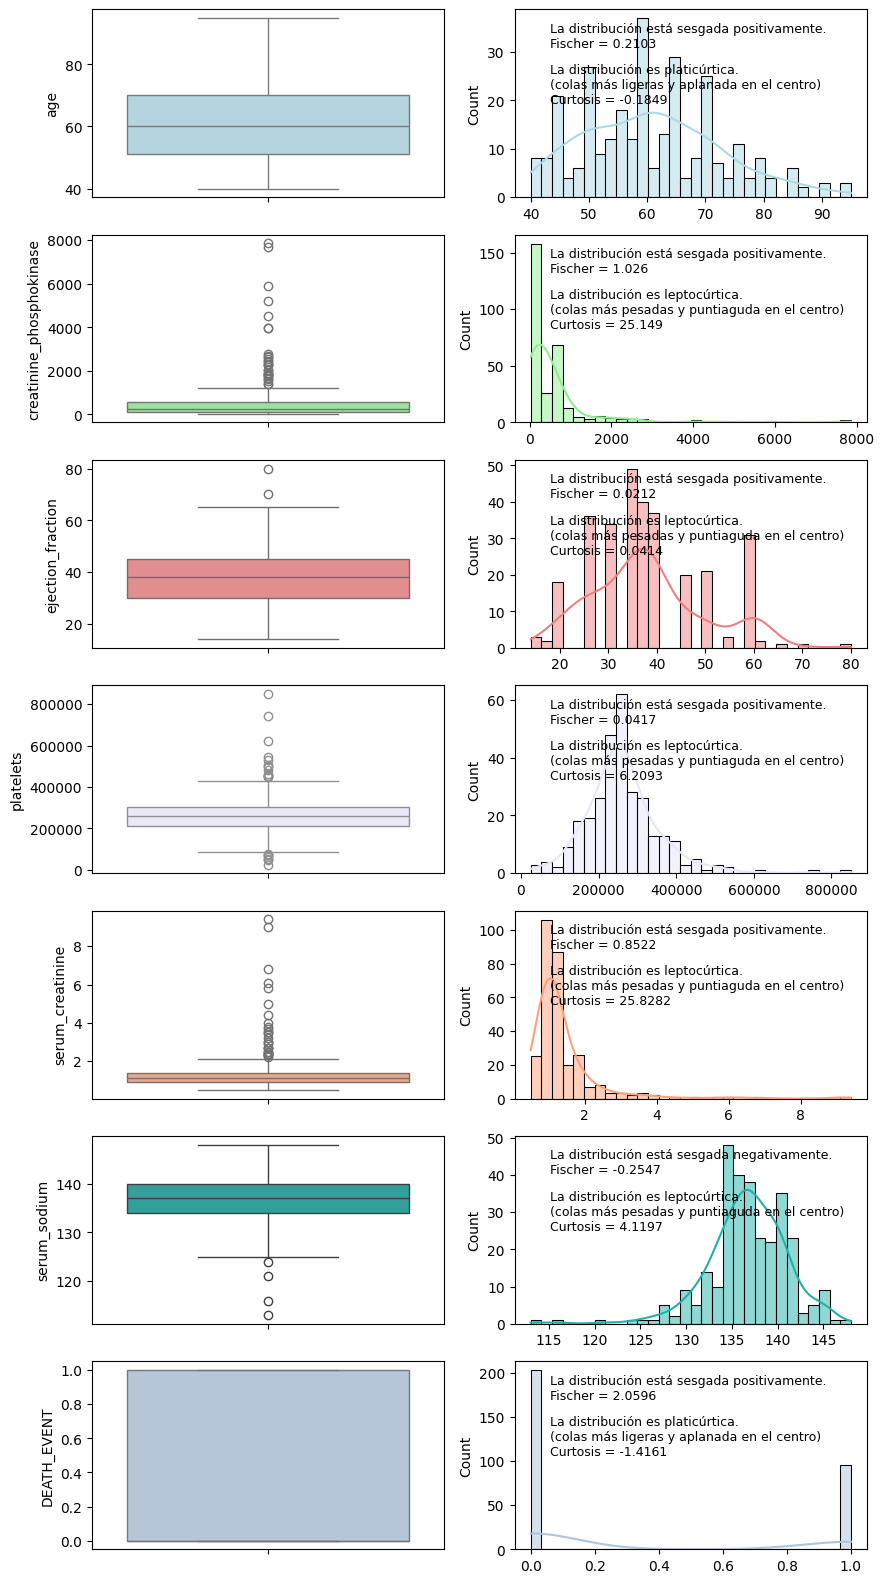

In [44]:
fig, axs = plt.subplots(7, 2, figsize=(10, 20))
i = 0

for column in heart_df.columns:
    grafica(heart_df, column, axs, i)
    i += 1

plt.show()

### Remoción de datos atípicos

In [ ]:
def remove_outliers_iqr(data):
    
    # Calculate the first quartile (Q1) and third quartile (Q3)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    
    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove outliers
    data = np.where(data>upper_bound, upper_bound, np.where(data<lower_bound,lower_bound,data))
    return data[(data >= lower_bound) & (data <= upper_bound)]

Se decidió utilizar los límites de los bigotes como valor que va a ser reemplazado en los datos atípicos. Esto debido a los posibles errores en la toma de datos y a que en un modelo predictivo es recomendable mantener estos datos cercanos al original. 

In [48]:
for i in heart_df.columns:
    heart_df[i] = remove_outliers_iqr(heart_df[i])

### Mapa de calor y gráficos con los datos reemplazados

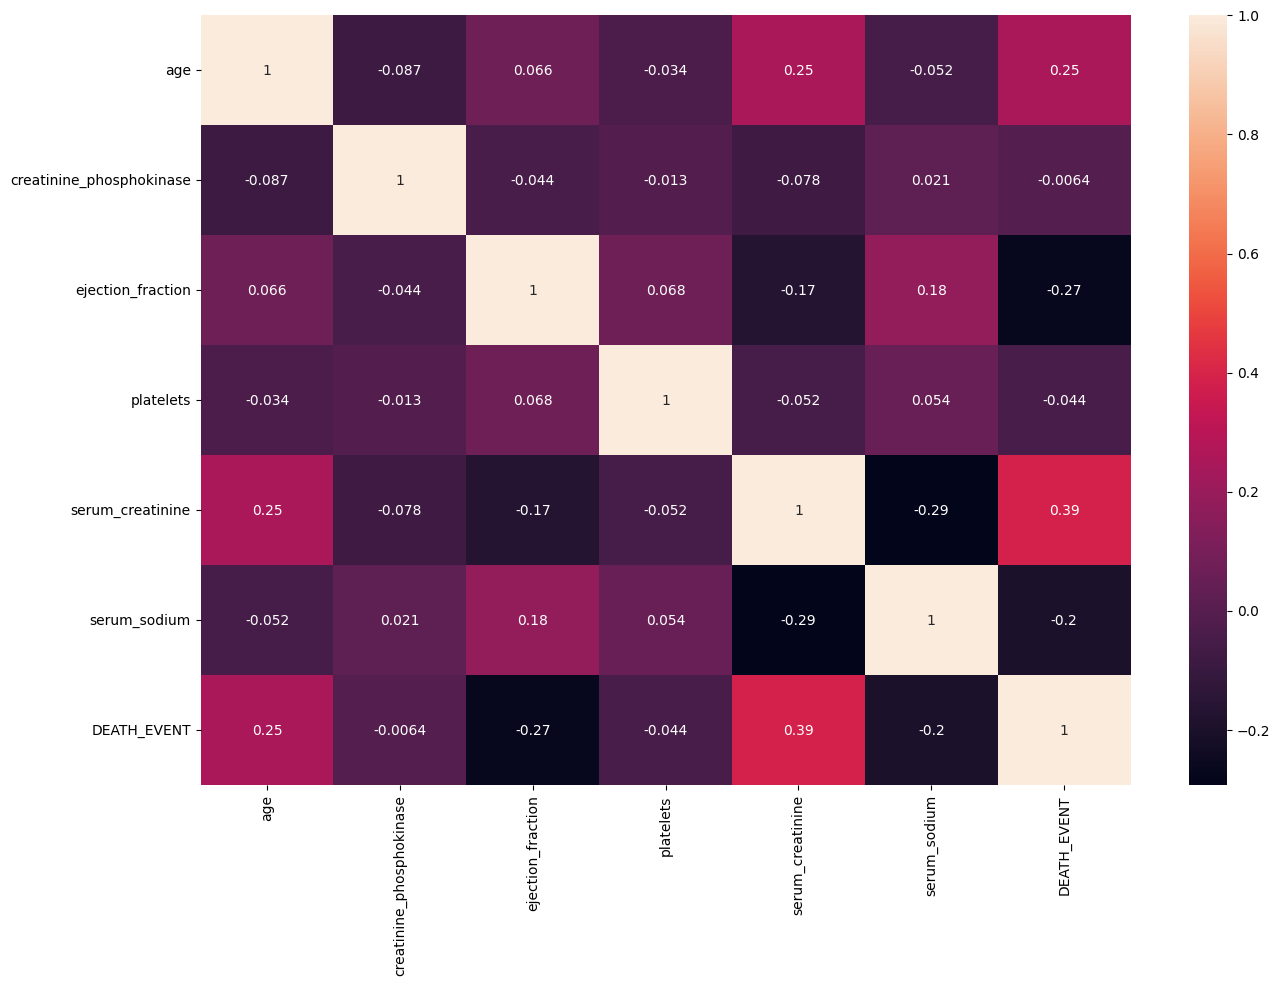

In [51]:
plt.figure(figsize=(15,10))
sns.heatmap(heart_df.corr(),fmt='.2g',annot=True)
plt.show()

NO EXISTE correlación significativa entre las columnas.

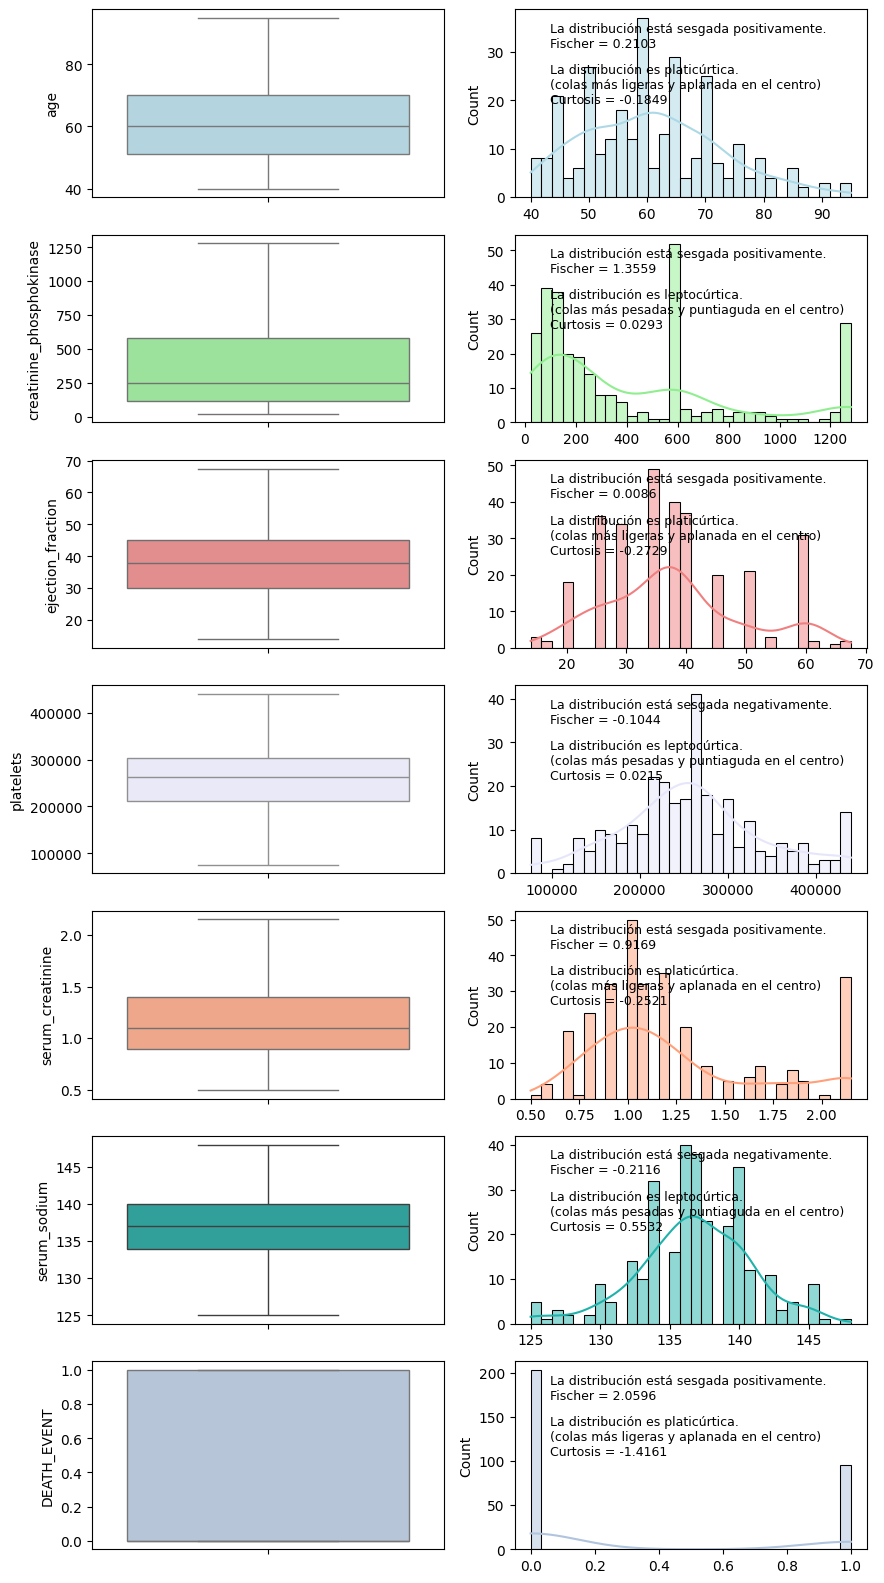

In [50]:
fig, axs = plt.subplots(7, 2, figsize=(10, 20))
i = 0

for column in heart_df.columns:
    grafica(heart_df, column, axs, i)
    i += 1

plt.show()

Debido a que reemplazamos los datos atípicos se crearon una acumulación de datos en los bordes de las gráficas de frecuencias cambiando las formas de las gráficas, sin embargo, no es necesario considerar la forma de las gráficas para el modelo.